In [1]:
# Import des librairies
from tensorflow.keras.datasets import imdb
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Charger les données en utilisant imdb.load_data() avec un vocabulaire limité
top_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)

# 'x_train' contient les données d'entraînement sous forme de séquences d'entiers
# 'y_train' contient les étiquettes correspondantes (positif/négatif)
# 'x_test' contient les données de test sous forme de séquences d'entiers
# 'y_test' contient les étiquettes correspondantes pour les données de test

In [3]:
# Convertir les listes d'entiers en une matrice de 0 et de 1 (encodage One-Hot)
# Instancier l'encodeur One-Hot (non sparse)
encoder = OneHotEncoder(sparse=False)

# Définir une fonction pour convertir une séquence en une matrice One-Hot
def sequence_to_matrix(sequence, num_words):
    # Initialiser une matrice de zéros de la taille spécifiée
    matrix = np.zeros(num_words)
    
    # Parcourir les indices des mots dans la séquence
    for word_index in sequence:
        # Vérifier si l'indice du mot est inférieur au nombre de mots maximum (num_words)
        if word_index < num_words:
            # Si c'est le cas, marquer la position correspondante dans la matrice comme 1
            matrix[word_index] = 1
    return matrix

# Appliquer la fonction de conversion aux données d'entraînement
x_train_one_hot = np.array([sequence_to_matrix(sequence, top_words) for sequence in x_train])

# Appliquer la fonction de conversion aux données de test
x_test_one_hot = np.array([sequence_to_matrix(sequence, top_words) for sequence in x_test])

In [4]:
# Diviser les données d'entraînement en données d'entraînement et de validation
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_one_hot, y_train, test_size=0.2, random_state=42
)

In [5]:
# Définir les hyperparamètres à rechercher
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
}

In [6]:
# Initialiser le modèle RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

In [7]:
# Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_split, y_train_split)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [8]:
# Obtenir les meilleurs hyperparamètres et le meilleur score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Meilleurs hyperparamètres trouvés : ", best_params)
print("Meilleur score d'accuracy : ", best_score)

Meilleurs hyperparamètres trouvés :  {'max_depth': None, 'n_estimators': 300}
Meilleur score d'accuracy :  0.8555499999999998


In [9]:
# Entraîner le modèle RandomForest avec les meilleurs hyperparamètres
best_rf_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                      max_depth=best_params['max_depth'],
                                      random_state=42, verbose=1)
best_rf_model.fit(x_train_split, y_train_split)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   35.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.4min


RandomForestClassifier(n_estimators=300, random_state=42, verbose=1)

In [10]:
# Prédiction sur les données de validation
y_val_pred = best_rf_model.predict(x_val_split)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


In [11]:
# Évaluer les performances du modèle sur l'ensemble de validation
accuracy = accuracy_score(y_val_split, y_val_pred)
print(f"Accuracy on validation set: {accuracy:.2f}")

Accuracy on validation set: 0.86


In [12]:
# Prédiction sur l'ensemble de test
y_test_pred = best_rf_model.predict(x_test_one_hot)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.2s


In [13]:
# Évaluer les performances du modèle sur l'ensemble de test
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test set: {test_accuracy:.2f}")

Accuracy on test set: 0.85


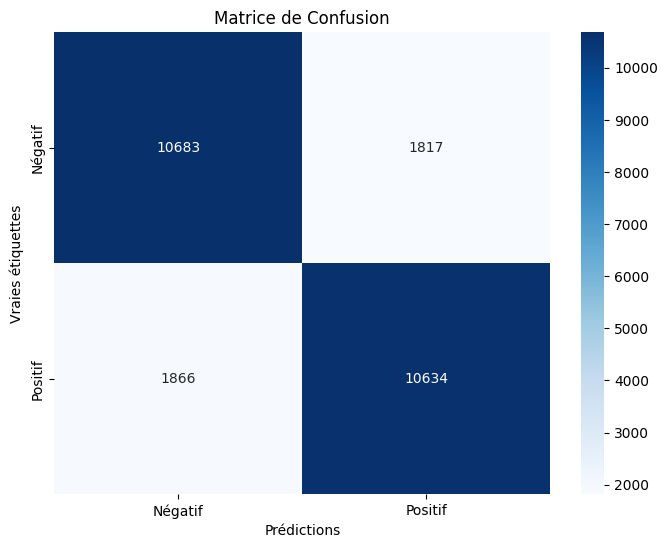

In [14]:
# Calculer la matrice de confusion sur l'ensemble de test
confusion = confusion_matrix(y_test, y_test_pred)

# Créer une représentation visuelle de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

In [15]:
# Afficher le rapport de classification
target_names = ['Négatif', 'Positif']
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

     Négatif       0.85      0.85      0.85     12500
     Positif       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

